#RFM CUSTOMER SEGMENTATION


# Customer Segmentation Using RFM Analysis

Customer segmentation helps businesses tailor marketing and retention strategies.  
In this section, we apply RFM (Recency, Frequency, Monetary) analysis to segment customers based on purchasing behavior.


## RFM Feature Engineering

We calculate Recency, Frequency, and Monetary values for each customer:
- **Recency**: Days since the customer’s last purchase
- **Frequency**: Number of unique transactions
- **Monetary**: Total revenue generated by the customer


In [2]:
import pandas as pd

file_path = "customer.xlsx"
df = pd.read_excel(file_path)
df['Revenue'] = df['Quantity'] * df['UnitPrice']
sales_df = df[df['Quantity'] > 0]
sales_df = sales_df[sales_df['UnitPrice'] > 0]
#Handle Missing CustomerID
sales_df = sales_df.dropna(subset=['CustomerID'])
#Sanity Check After Cleaning
sales_df.describe()
sales_df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
Revenue,0


In [3]:
import datetime as dt

snapshot_date = sales_df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = (
    sales_df
    .groupby('CustomerID')
    .agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'nunique',
        'Revenue': 'sum'
    })
)

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


### Distribution of RFM Metrics

Understanding the distribution of RFM metrics helps identify skewness and outliers before scoring customers.


In [4]:
rfm.describe()


,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


### RFM Scoring

Customers are ranked into quartiles for each RFM metric.  
Higher scores indicate better customer value.


In [5]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 4, labels=False, duplicates='drop').astype(int) + 1
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

rfm['RFM_Score'] = (
    rfm['R_Score'].astype(str) +
    rfm['F_Score'].astype(str) +
    rfm['M_Score'].astype(str)
)

rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,4,114
12347.0,2,7,4310.00,4,3,4,434
12348.0,75,4,1797.24,2,2,4,224
12349.0,19,1,1757.55,3,1,4,314
12350.0,310,1,334.40,1,1,2,112


### Customer Segmentation

Based on RFM scores, customers are grouped into meaningful business segments.


In [6]:
def segment_customer(row):
    if row['RFM_Score'] >= '444':
        return 'Champions'
    elif row['RFM_Score'] >= '344':
        return 'Loyal Customers'
    elif row['RFM_Score'] >= '244':
        return 'Potential Loyalists'
    elif row['RFM_Score'] >= '144':
        return 'At Risk'
    else:
        return 'Low Value'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
rfm['Segment'].value_counts()


,count
Segment,
Loyal Customers,1125
Low Value,1084
At Risk,1066
Potential Loyalists,1063


### Segment-Level Performance Analysis

We analyze how each customer segment contributes to overall revenue.


In [7]:
segment_summary = (
    rfm.groupby('Segment')
    .agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean'
    })
    .sort_values(by='Monetary', ascending=False)
)

segment_summary


,Recency,Frequency,Monetary
Segment,,,
Loyal Customers,8.496000,8.611556,4657.096462
Potential Loyalists,32.229539,4.014111,1753.616981
At Risk,84.313321,2.639775,1032.703023
Low Value,246.980627,1.626384,652.415232


## RFM Insights

- **Champions** represent the most valuable customers with frequent and recent purchases.
- **Loyal Customers** consistently generate revenue and are ideal for retention campaigns.
- **At Risk** customers show declining engagement and require targeted reactivation strategies.
- **Low Value** customers contribute minimal revenue and may not justify high acquisition costs.


## RFM-Based Business Recommendations

- Reward Champions with exclusive offers and early product access.
- Upsell and cross-sell to Loyal Customers.
- Launch re-engagement campaigns for At Risk customers.
- Limit marketing spend on Low Value segments.


# Data Visualization and Insights

In this section, we use visualizations to explore revenue trends, geographic performance, product concentration, and customer segments. Visual insights help communicate patterns more effectively to business stakeholders.


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


## Revenue Distribution

This plot shows the distribution of revenue at the transaction level.  
Retail revenue is typically right-skewed, where a small number of transactions contribute disproportionately to total sales.


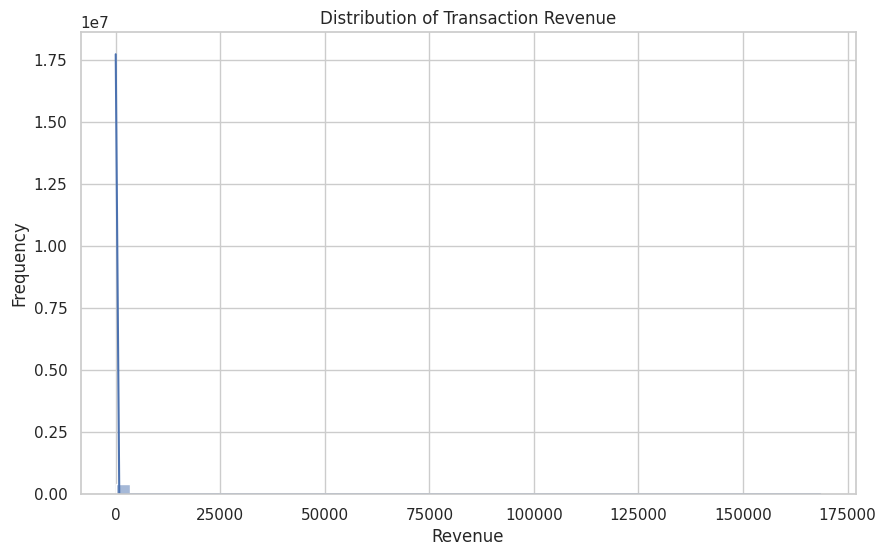

In [9]:
sns.histplot(sales_df['Revenue'], bins=50, kde=True)
plt.title("Distribution of Transaction Revenue")
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.show()


## Top 10 Countries by Revenue

This visualization highlights the countries contributing the highest revenue and helps identify geographic concentration and growth opportunities.


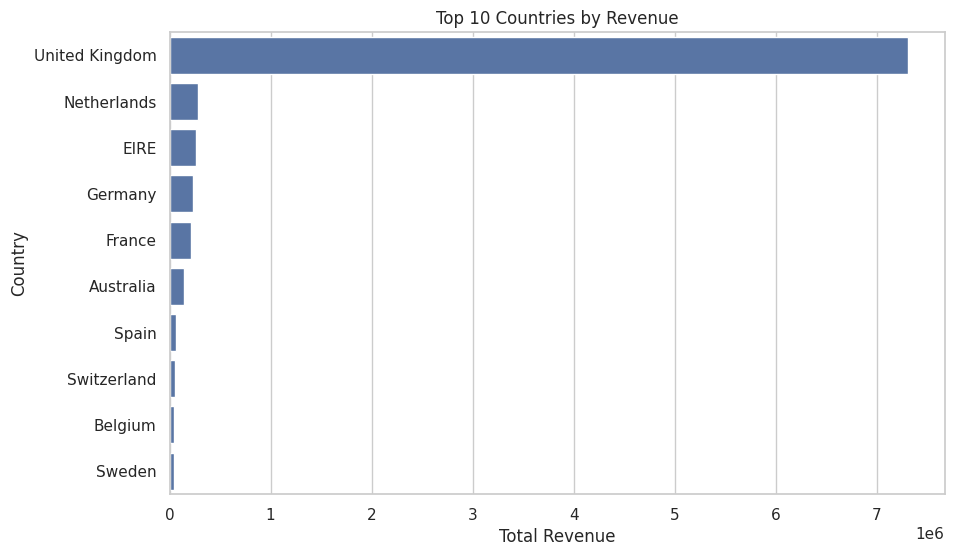

In [10]:
top_countries = (
    sales_df.groupby('Country')['Revenue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

sns.barplot(
    x=top_countries.values,
    y=top_countries.index
)
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Total Revenue")
plt.ylabel("Country")
plt.show()


## Top 10 Products by Revenue

This chart identifies the products that generate the highest revenue and can inform inventory planning and marketing strategies.


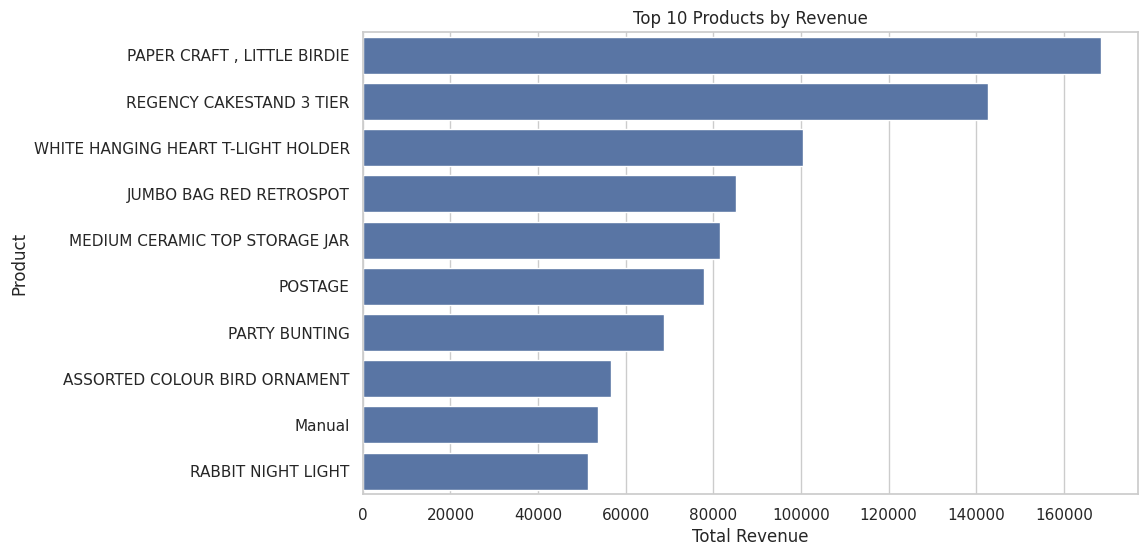

In [11]:
top_products = (
    sales_df.groupby('Description')['Revenue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

sns.barplot(
    x=top_products.values,
    y=top_products.index
)
plt.title("Top 10 Products by Revenue")
plt.xlabel("Total Revenue")
plt.ylabel("Product")
plt.show()


## Monthly Revenue Trend

Analyzing monthly revenue trends helps identify seasonality and peak sales periods, which are critical for demand forecasting and promotional planning.


/tmp/ipython-input-4253370296.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')['Revenue']


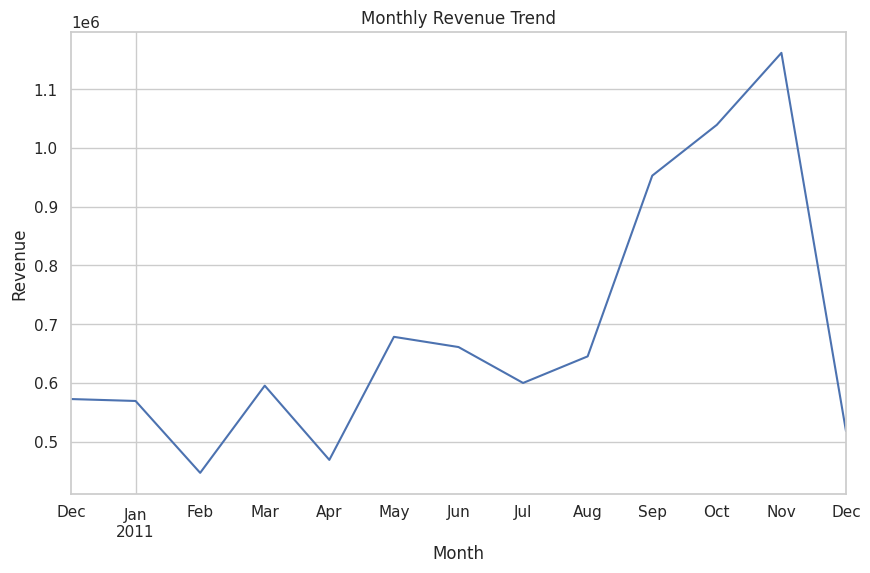

In [12]:
monthly_revenue = (
    sales_df
    .set_index('InvoiceDate')
    .resample('M')['Revenue']
    .sum()
)

monthly_revenue.plot()
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()


## Customer Segment Distribution

This visualization shows the distribution of customers across RFM-based segments, helping assess overall customer quality and engagement levels.


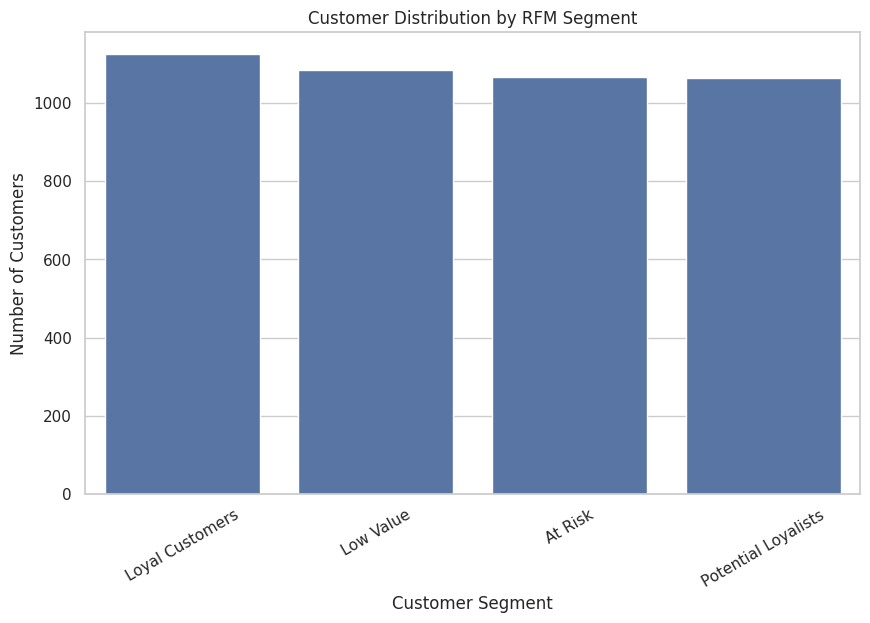

In [13]:
segment_counts = rfm['Segment'].value_counts()

sns.barplot(
    x=segment_counts.index,
    y=segment_counts.values
)
plt.title("Customer Distribution by RFM Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=30)
plt.show()


## Revenue Contribution by Customer Segment

This chart shows how different RFM segments contribute to total revenue, highlighting which customer groups drive the business.


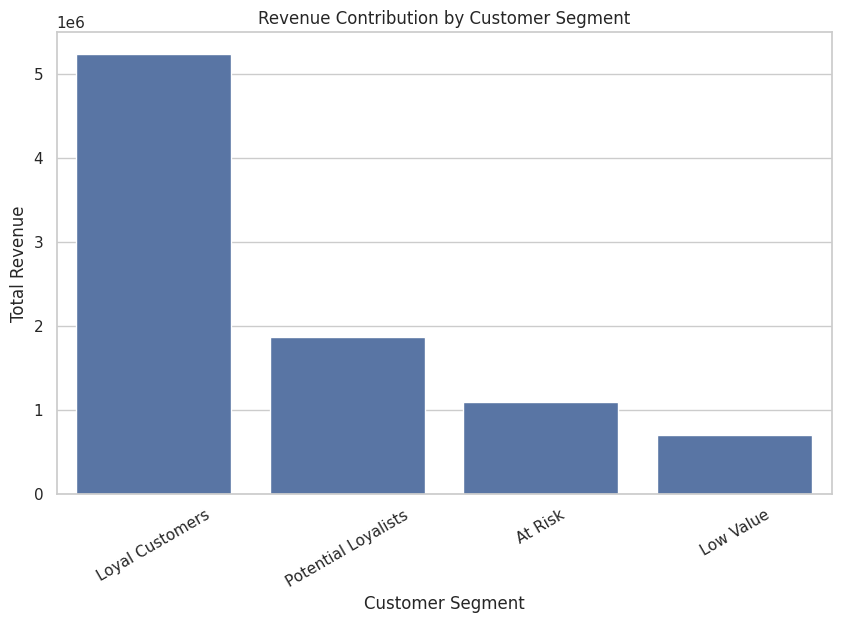

In [14]:
segment_revenue = (
    rfm.groupby('Segment')['Monetary']
    .sum()
    .sort_values(ascending=False)
)

sns.barplot(
    x=segment_revenue.index,
    y=segment_revenue.values
)
plt.title("Revenue Contribution by Customer Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Total Revenue")
plt.xticks(rotation=30)
plt.show()


## Visualization Insights

- Revenue distribution is highly skewed, indicating that a small subset of transactions and customers drives most sales.
- The United Kingdom dominates revenue contribution, suggesting geographic concentration risk.
- A limited number of products account for a significant share of revenue.
- Clear seasonal patterns are observed in monthly revenue trends.
- RFM analysis shows that high-value customer segments generate disproportionate revenue relative to their size.
